In [1]:
## disabeling warning msg
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush() # resolving tqdm problem

# Model

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

E0000 00:00:1762436071.020692      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762436071.073305      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
#####################################################################################
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
#####################################################################################################################
def mse_score(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [4]:
def dual_decoder_unet_binary(IMG_CHANNELS, LearnRate):
    inputs = Input((None, None, IMG_CHANNELS))
    #encoder
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)


    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    ## decoder for dis unet
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs1 = Conv2D(1, (1, 1), activation='linear', name='output_dis')(c9)


    ## decoder for segmentation unet
    u6_seg = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_seg = concatenate([u6_seg, c4])
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_seg)
    c6_seg = Dropout(0.2)(c6_seg)
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_seg)

    u7_seg = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_seg)
    u7_seg = concatenate([u7_seg, c3])
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_seg)
    c7_seg = Dropout(0.2)(c7_seg)
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_seg)

    u8_seg = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_seg)
    u8_seg = concatenate([u8_seg, c2])
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_seg)
    c8_seg = Dropout(0.1)(c8_seg)
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_seg)

    u9_seg = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_seg)
    u9_seg = concatenate([u9_seg, c1], axis=3)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_seg)
    c9_seg = Dropout(0.1)(c9_seg)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_seg)

    outputs2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_seg')(c9_seg)

    model_dual_path = models.Model(inputs=[inputs], outputs=[outputs1, outputs2])
    model_dual_path.compile(optimizer=Adam(learning_rate=LearnRate),
                            loss={'output_dis': 'mean_squared_error', 'output_seg': bce_dice_loss},
                            loss_weights=  {'output_dis': 1.0, 'output_seg': 1.0},
                            metrics={'output_seg':dice_coef, 'output_dis':mse_score})
    # model_dual_path.summary()
    return model_dual_path

In [5]:
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    #print(len(pred_id_list))
    if len(pred_id_list) == 1:
        return 0

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    #print(aji_score)
    return aji_score

#############################################################################################################
def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    
    if len(pred_id_list) == 1:
        return [0, 0, 0], [0,0, 0, 0]

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#############################################################################################################
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    dice_score = 2.0 * np.sum(inter) / (np.sum(denom) + 0.0001)
    if np.sum(inter)==0 and np.sum(denom)==0:
        dice_score = 1 # to handel cases without any nuclei
    #print(dice_score)
    return dice_score
#############################################################################################################
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred


In [6]:
#x = dual_decoder_unet_binary(3,0.001)

In [7]:
#x.summary()

In [8]:
# set all hyper parameters
opts = {}
opts['number_of_channel'] = 3                   
opts['treshold'] = 0.5                          
opts['epoch_num'] = 120             
opts['quick_run'] = 1   
opts['batch_size'] = 8                         
opts['random_seed_num'] = 19   
opts['k_fold'] = 2                          
opts['save_val_results'] = 1         
opts['init_LR'] = 0.001                         
opts['LR_decay_factor'] = 0.5                   
opts['LR_drop_after_nth_epoch'] = 20            
opts['crop_size'] = 512   
## output directories
opts['result_save_path'] ='/kaggle/working/prediction_image/'
opts['model_save_path'] ='/kaggle/working/output_model/'

In [9]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.1, epochs_drop=20):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))
    
    return LearningRateScheduler(schedule, verbose = 1)

# Data Preperation

In [10]:
base_path = '../input/nuinsseg/'
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['mouse muscle_tibia',
 'mouse liver',
 'human liver',
 'human umbilical cord',
 'mouse thymus',
 'human lung',
 'human epiglottis',
 'human spleen',
 'mouse fat (white and brown)_subscapula',
 'human cardia',
 'human salivory gland',
 'human melanoma',
 'human kidney',
 'human pylorus',
 'human jejunum',
 'human testis',
 'mouse spleen',
 'human tongue',
 'human cerebellum',
 'human oesophagus',
 'mouse heart',
 'human pancreas',
 'human brain',
 'human muscle',
 'human placenta',
 'human bladder',
 'mouse kidney',
 'human tonsile',
 'human rectum',
 'mouse femur',
 'human peritoneum']

In [11]:
import os
from glob import glob

img_path = glob('{}*{}'.format('../input/nuinsseg/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/label masks modify/', 'tif'))
vague_mask_path =  glob('{}*{}'.format('../input/nuinsseg/*/vague areas/mask binary/', 'png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('/kaggle/working/prediction_image/'):
    os.makedirs('/kaggle/working/prediction_image/')
if not os.path.exists('/kaggle/working/output_model/'):
    os.makedirs('/kaggle/working/output_model/')    
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')  


In [12]:
#random check
import numpy as np
import random
rand_num = np.random.randint(len(img_path))
print('image path: {}\n'.format(img_path[rand_num]),
      'binary mask path: {}\n'.format(binary_mask_path[rand_num]),
      'distance mask path: {}\n'.format(distance_mask_path[rand_num]),
      'label mask path: {}\n'.format(label_mask_path[rand_num]))

image path: ../input/nuinsseg/human tonsile/tissue images/human_tonsile_10.png
 binary mask path: ../input/nuinsseg/human tonsile/mask binary/human_tonsile_10.png
 distance mask path: ../input/nuinsseg/human tonsile/distance maps/human_tonsile_10.png
 label mask path: ../input/nuinsseg/human tonsile/label masks modify/human_tonsile_10.tif



In [13]:
# augmentation function
import albumentations 
def albumentation_aug(p=1.0, crop_size_row = 448, crop_size_col = 448 ):
    return albumentations.Compose([
        albumentations.RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1),
        albumentations.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, brightness_by_max=True, p=0.4),
        albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.1),
        albumentations.HorizontalFlip(always_apply=False, p=0.5),
        albumentations.VerticalFlip(always_apply=False, p=0.5),
        albumentations.RandomRotate90(p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1, 
                         border_mode=4, always_apply=False, p=0.1),

    ], p=p)

# aug =albumentation_aug()

# KFold

In [14]:
from random import shuffle
import cv2
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
import tqdm

In [15]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = KFold(n_splits= opts['k_fold'],random_state= opts['random_seed_num'],shuffle=True)
kf.get_n_splits(img_path)

2

In [16]:
import os
import cv2
import numpy as np
# Make sure you have albumentations installed
# import albumentations as A 

# Helper function to find borders between touching instances
def get_touching_borders(instance_mask):
    """
    Finds pixels that represent the border between two touching instances.
    
    Args:
        instance_mask (np.array): A 2D array where each instance is 
                                  labeled with a unique integer.
    
    Returns:
        np.array: A 2D binary mask (0 or 1) where '1' marks a
                  pixel that lies on the border between two instances.
    """
    # Use a 3x3 kernel for dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    # Get all unique labels (excluding background 0)
    labels = np.unique(instance_mask)
    labels = labels[labels != 0]
    
    touching_borders = np.zeros_like(instance_mask, dtype=np.uint8)

    for label in labels:
        # Create a mask for the current instance
        instance = (instance_mask == label).astype(np.uint8)
        
        # Dilate this instance
        dilated_instance = cv2.dilate(instance, kernel, iterations=1)
        
        # Find where the dilated part overlaps with *other* instances
        # (instance_mask > 0) -> any instance
        # (instance_mask != label) -> not this instance
        other_instances_mask = (instance_mask > 0) & (instance_mask != label)
        
        # The border is where the dilated part of *this* instance
        # touches *another* instance's mask
        border = (dilated_instance > 0) & (other_instances_mask > 0)
        touching_borders[border] = 1
        
    return touching_borders

# # Simplified chunker for two lists
# def chunker(seq, seq2, size):
#     return ([seq[pos:pos + size], seq2[pos:pos + size]] for pos in range(0, len(seq), size))

def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')

In [17]:
## Data Generator Needed not to run out of 
import os
import cv2
import numpy as np
def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')
    
def chunker(seq, seq2, seq3, size):
    return ([seq[pos:pos + size], seq2[pos:pos + size], seq3[pos:pos + size]] for pos in range(0, len(seq), size))

def data_gen(list_files, list_files2, list_files3, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    crop_size_row = size_row
    crop_size_col = size_col
    aug = albumentation_aug(p, crop_size_row, crop_size_col)
    while True:
        for batch in chunker(list_files, list_files2, list_files3, batch_size):
            Y = []
            Y_seg = []
            Y_dis = []
            X = []
            
            image_paths = batch[0]
            # mask_paths = batch[1]
            dis_paths = batch[2] 
            inst_path = batch[1]

            for count in range(len(image_paths)):
                # 1. Load Image (X)
                x = cv2.imread(image_paths[count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                
                # 2. Load Segmentation Mask (Y_seg) - For output_seg w/o borders
                # seg_mask = cv2.imread(mask_paths[count], cv2.IMREAD_GRAYSCALE)

                erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

                orig_instance_mask = cv2.imread(inst_path[count], cv2.IMREAD_UNCHANGED)
                binary_mask = (orig_instance_mask > 0).astype(np.uint8)
                touching_borders = get_touching_borders(orig_instance_mask)
                mask_no_borders = binary_mask - touching_borders
                seg_mask = cv2.erode(mask_no_borders, erosion_kernel, iterations=1)
                
                # 3. Load Distance Map (Y_dis) - For output_dis
                dis_map = cv2.imread(dis_paths[count], cv2.IMREAD_GRAYSCALE)

                if augment:
                    augmented = aug(image= x, mask= seg_mask, dis = dis_map)
                    x = augmented['image']
                    seg_mask = augmented['mask']
                    dis_map = augmented['dis']
                    
                x = x/255.0

                # seg_mask = (seg_mask - np.min(seg_mask))/ (np.max(seg_mask) - np.min(seg_mask) + 0.0000001)

                # dis_map = dis_map / 255.0
                min_dis = np.min(dis_map)
                max_dis = np.max(dis_map)
                if (max_dis - min_dis) > 0.0000001:
                    dis_map = (dis_map - min_dis) / (max_dis - min_dis)
                else:
                    dis_map = np.zeros_like(dis_map) # Handle case of all-zero mask

                x = x.astype(np.float32)
                dis_map = dis_map.astype(np.float32)
                seg_mask = (seg_mask > 0).astype(np.float32) 
                # min_dis = np.min(dis_map)
                # max_dis = np.max(dis_map)
                # dis_map = (dis_map - min_dis) / (max_dis - min_dis + 0.0000001)

                X.append(x)
                Y_seg.append(seg_mask)
                Y_dis.append(dis_map)
                
                del x, seg_mask, dis_map, orig_instance_mask
            X = np.array(X)
            Y_seg = np.expand_dims(np.array(Y_seg), axis=-1)
            Y_dis = np.expand_dims(np.array(Y_dis), axis=-1)
            yield X, {'output_seg': Y_seg, 'output_dis': Y_dis}
                

In [18]:
import numpy as np
from scipy.ndimage import gaussian_filter

def apply_gaussian_smoothing(distance_map_array, average_diameter):
    """
    Applies Gaussian smoothing to the predicted distance map.
    
    Args:
        distance_map_array (np.ndarray): The 2D distance map predicted by the UNet head.
        average_diameter (float): The average nucleus equivalent diameter (in pixels).
                                  
    Returns:
        np.ndarray: The smoothed distance map, ready for watershed markers extraction.
    """
    # Set the standard deviation (sigma, σ) for the Gaussian filter.
    # Sigma is typically set to the average radius of the object (Diameter / 2).
    # This choice ensures the filter smooths the distance peaks for *one* nucleus, 
    # while generally preserving the boundaries between overlapping nuclei.
    GAUSSIAN_SIGMA = average_diameter / 2.0
    
    # Apply the Gaussian filter. 
    # truncate=4.0 ensures the kernel covers about 4 standard deviations, making 
    # the smoothing effective.
    smoothed_dis_map = gaussian_filter(
        input=distance_map_array, 
        sigma=GAUSSIAN_SIGMA, 
        truncate=4.0
    )
    
    return smoothed_dis_map

In [19]:
import numpy as np
from skimage.measure import label, regionprops
from math import sqrt, pi
from scipy.ndimage import gaussian_filter # Needed for the next step

def calculate_average_nucleus_diameter(binary_mask_array, min_area_threshold=50):
    """
    Calculates the average equivalent nucleus diameter (in pixels) from the 
    predicted binary semantic mask.
    
    The diameter is derived from the average nucleus area, assuming a circular shape 
    (Area = pi * (D/2)^2 => D = 2 * sqrt(Area / pi)).
    
    Args:
        binary_mask_array (np.ndarray): The 2D numpy array of the predicted 
                                        binary semantic mask (0s and 1s).
        min_area_threshold (int): Filters out small regions (noise) that are not nuclei.
                                  
    Returns:
        float: The average nucleus equivalent diameter in pixels.
    """
    # 1. Label connected components to identify individual (or clustered) nuclei
    # Use boolean array for skimage.label
    labeled_mask = label(binary_mask_array > 0)

    # 2. Calculate properties (Area) for each labeled region
    props = regionprops(labeled_mask)
    all_areas = []

    # 3. Collect areas
    for prop in props:
        if prop.area >= min_area_threshold:
            all_areas.append(prop.area)

    if not all_areas:
        # Fallback to a common size if no objects are detected
        return 20.0 

    # 4. Calculate average area
    average_area = np.mean(all_areas)
    
    # 5. Convert average area to equivalent diameter (D)
    average_diameter_pixels = 2 * sqrt(average_area / pi)
    
    return average_diameter_pixels

In [20]:
# dice_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# AJI_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# PQ_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])


# dice_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# AJI_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# PQ_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

# dice_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# AJI_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
# PQ_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

# Calculate the maximum size required for any fold (using ceiling division)
num_folds = opts['k_fold']
total_images = len(img_path)
max_fold_size = (total_images + num_folds - 1) // num_folds

# Initialize all arrays using the calculated maximum fold size
dice_unet = np.zeros([num_folds, max_fold_size])
AJI_unet = np.zeros([num_folds, max_fold_size])
PQ_unet = np.zeros([num_folds, max_fold_size])

dice_unet_watershed = np.zeros([num_folds, max_fold_size])
AJI_unet_watershed = np.zeros([num_folds, max_fold_size])
PQ_unet_watershed = np.zeros([num_folds, max_fold_size])

dice_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])
AJI_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])
PQ_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])

dice_mean = []
aji_mean = []
pq_mean = []
                   
dice_watershed_mean = []
aji_watershed_mean = []
pq_watershed_mean = []
                   
dice_watershed_wovague_mean = []
aji_watershed_wovague_mean = []
pq_watershed_wovague_mean = []


In [21]:
current_fold = 1

import time
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import skimage.morphology
from skimage.io import imsave
from skimage.morphology import remove_small_objects
import tqdm
import pandas as pd

start_time = time.time()
for index,[train_index,  test_index] in enumerate(kf.split(img_path)):
    
    shuffle(train_index)
    shuffle(test_index)
    
    train_img   = [img_path[name] for name in train_index]
    train_mask  = [binary_mask_path[name] for name in train_index]
    train_DIS   = [distance_mask_path[name] for name in train_index]
    train_label = [label_mask_path[name] for name in train_index]

    test_img   = [img_path[name] for name in test_index]
    test_mask  = [binary_mask_path[name] for name in test_index]
    test_DIS   = [distance_mask_path[name] for name in test_index]
    test_label = [label_mask_path[name] for name in test_index]

    ## creating validation set ##
    
    validation_set_img = []
    validation_set_label = []
    validation_DIS = []
    # validation_set_vague = []
    # test_masks = []
    
    for counter in range(len(test_img)):
        val_img = cv2.imread(test_img[counter])
        val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
        val_img = val_img.astype(np.float32) / 255.0 
        validation_set_img.append(val_img)

        
        val_label = cv2.imread(test_label[counter], -1) # cv2.IMREAD_UNCHANGED: 
        #It specifies to load an image as such including alpha channel. 
        #Alternatively, we can pass integer value -1 for this flag.
        # val_vague = cv2.imread(test_vague[counter], -1)
        
        
        validation_set_label.append(val_label)
        # validation_set_vague.append(val_vague)
        
        # val_mask = cv2.imread(test_mask[counter],-1)
        # val_mask = val_mask.astype(np.float32) / 255.0         
        # test_masks.append(val_mask)
        
        # val_DIS = cv2.imread(test_DIS[counter], -1) 
        # val_DIS = val_DIS.astype(np.float32) / 255.0
        # validation_DIS.append(val_DIS)
        
    validation_set_img = np.array(validation_set_img)
    # validation_DIS = np.array(validation_DIS)

    # test_img = validation_set_img
    # test_mask = np.array(test_masks)
    # test_mask = np.expand_dims(test_mask, axis=-1)
    # test_DIS = np.expand_dims(validation_DIS, axis=-1)
    validation_set_label = np.array(validation_set_label)
    # validation_set_vague = np.array(validation_set_vague)

    

    model_path = opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold)
    logger = CSVLogger(opts['model_save_path']+ 'unet_{}.log'.format(current_fold))
    LR_drop = step_decay_schedule()
    model = dual_decoder_unet_binary(opts['number_of_channel'], opts['init_LR'])
    checkpoint = ModelCheckpoint(model_path, monitor='val_output_seg_dice_coef', verbose=1,
                         save_best_only=True, mode='max', save_weights_only = True)
    # history = model.fit(x=train_img,y={
    #                         'output_dis': train_DIS,  # Targets for the Distance Map head
    #                         'output_seg': train_mask    # Targets for the Segmentation Mask head
    #                     },
    #                     validation_data=(test_img,{
    #                         'output_dis': test_DIS,  # Targets for the Distance Map head
    #                         'output_seg': test_mask    # Targets for the Segmentation Mask head
    #                     }),  
    #                   #validation_steps=1,
    #                   epochs=opts['epoch_num'], verbose=1,
    #                   callbacks=[checkpoint, logger, LR_drop],
    #                   steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])

    history = model.fit(data_gen(train_img,train_label,train_DIS,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size']),
                        validation_data=data_gen(test_img,test_label,test_DIS,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size']),  
                      validation_steps=1,
                      epochs=opts['epoch_num'], verbose=1,
                      callbacks=[checkpoint, logger, LR_drop],
                      steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])
    
    model.load_weights(opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold))

    ## FOLD RESULTS ##

    pred_val = model.predict(validation_set_img, verbose=1, batch_size=1)

    pred_dis = pred_val[0]
    pred_seg = pred_val[1]

    pred_val_t = (pred_seg > opts['treshold']).astype(np.uint8) # Add this later
    pred_seg = pred_val_t

    for val_len in tqdm.tqdm(range(len(pred_dis))):
        avg_nuclei = calculate_average_nucleus_diameter(pred_seg[val_len])
        pred_dis[val_len] = apply_gaussian_smoothing(pred_dis[val_len],avg_nuclei)

        footprint_size = max(3, int(avg_nuclei * 0.8) // 2 * 2 + 1)
        
        peak_coords = peak_local_max(np.squeeze(pred_dis[val_len]), 
                              # indices=False,
                            exclude_border=False, footprint=np.ones((footprint_size, footprint_size)))
        image_shape = np.squeeze(pred_dis[val_len]).shape
        local_maxi = np.zeros(image_shape, dtype=bool)
        if peak_coords.size > 0:
    # Set the pixels at the peak coordinates to True
            local_maxi[peak_coords[:, 0], peak_coords[:, 1]] = True

        
        marker = ndi.label(local_maxi)[0]
        output_watershed = watershed(-np.squeeze(pred_dis[val_len]), marker,mask = np.squeeze(pred_val_t[[val_len]]))
        output_watershed[np.squeeze(pred_seg[[val_len]])==0] = 0
        output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)#remove small objects

        # output_raw_0 = np.squeeze(pred_seg[val_len])
        output_raw_binarized = (np.squeeze(pred_seg[val_len]) > opts['treshold']).astype(np.uint8)

        # 2. Apply labeling to the binary mask
        output_raw = skimage.morphology.label(output_raw_binarized) 
        # output_raw = skimage.morphology.label(output_raw_0)
        output_raw = remove_small_objects(output_raw, min_size=50, connectivity=2) #remove small objects

        output_watershed = remap_label(output_watershed)
        validation_set_label[val_len] = remap_label(validation_set_label[val_len])
        output_raw = remap_label(output_raw)
        
        test_name = get_id_from_file_path(test_img[val_len],'.png' )
        
        imsave(opts['result_save_path']+'validation/watershed_unet/{}.png'.format(test_name),
               output_watershed.astype(np.uint16))
        imsave(opts['result_save_path']+'validation/unet/{}.png'.format(test_name),output_raw.astype(np.uint16))

        dice_unet[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len], output_raw)
        AJI_unet[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_raw)
        PQ_unet[current_fold-1, val_len] = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]
        
        
        dice_unet_watershed[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len],output_watershed)
        AJI_unet_watershed[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_watershed)
        PQ_unet_watershed[current_fold-1, val_len]  = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]

    print('==========')    
    print('average dice pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(dice_unet[current_fold-1, :]*100)))
    print('average AJI pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(AJI_unet[current_fold-1, :]*100)))
    print('average PQ pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(PQ_unet[current_fold-1, :]*100)))
    dice_mean.append(np.mean(dice_unet[current_fold-1, :]*100))
    aji_mean.append(np.mean(AJI_unet[current_fold-1, :]*100))
    pq_mean.append(np.mean(PQ_unet[current_fold-1, :]*100))
    print('==========') 
    
    print('==========')    
    print('average Dice Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                   np.mean(dice_unet_watershed[current_fold-1, :]*100)))
    print('average AJI Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                  np.mean(AJI_unet_watershed[current_fold-1, :]*100)))
    print('average PQ Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                 np.mean(PQ_unet_watershed[current_fold-1, :]*100)))
    dice_watershed_mean.append(np.mean(dice_unet_watershed[current_fold-1, :]*100))
    aji_watershed_mean.append(np.mean(AJI_unet_watershed[current_fold-1, :]*100))
    pq_watershed_mean.append(np.mean(PQ_unet_watershed[current_fold-1, :]*100))
    print('==========') 
        
        
        
        
    
    current_fold += 1
    
finish_time = time.time() 



I0000 00:00:1762436101.089832      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/120


I0000 00:00:1762436118.179292      62 service.cc:148] XLA service 0x7c3a90003520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762436118.180286      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762436119.790816      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762436142.816833      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0982 - output_dis_loss: 0.0146 - output_dis_mse_score: 0.0146 - output_seg_dice_coef: 0.1914 - output_seg_loss: 0.0836
Epoch 1: val_output_seg_dice_coef improved from -inf to 0.19015, saving model to /kaggle/working/output_model/unet_1.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 642ms/step - loss: 0.0971 - output_dis_loss: 0.0146 - output_dis_mse_score: 0.0146 - output_seg_dice_coef: 0.1915 - output_seg_loss: 0.0825 - val_loss: 0.0342 - val_output_dis_loss: 0.0104 - val_output_dis_mse_score: 0.0104 - val_output_seg_dice_coef: 0.1902 - val_output_seg_loss: 0.0238 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/120


E0000 00:00:1762436172.680513      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762436172.914533      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: -0.0766 - output_dis_loss: 0.0134 - output_dis_mse_score: 0.0134 - output_seg_dice_coef: 0.2781 - output_seg_loss: -0.0908
Epoch 2: val_output_seg_dice_coef improved from 0.19015 to 0.28616, saving model to /kaggle/working/output_model/unet_1.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 410ms/step - loss: -0.0775 - output_dis_loss: 0.0134 - output_dis_mse_score: 0.0134 - output_seg_dice_coef: 0.2788 - output_seg_loss: -0.0917 - val_loss: -0.1413 - val_output_dis_loss: 0.0086 - val_output_dis_mse_score: 0.0086 - val_output_seg_dice_coef: 0.2862 - val_output_seg_loss: -0.1500 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: -0.2041 - output_dis_loss: 0.0109 - output_dis_mse_score: 0.0109 - output_seg_dice_coef: 0.3713 - output_seg_loss: -0.2173
Epoch 3: val_output_seg_dice_coef improved from 0.28616 to 0.33012, saving model to /kaggle/working/o

100%|██████████| 333/333 [01:48<00:00,  3.06it/s]


average dice pure Unet for fold1: 68.59
average AJI pure Unet for fold1: 38.91
average PQ pure Unet for fold1: 33.94
average Dice Unet watershed for fold1: 62.04
average AJI Unet watershed for fold1: 35.32
average PQ Unet watershed for fold1: 30.54

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 0.1058 - output_dis_loss: 0.0149 - output_dis_mse_score: 0.0149 - output_seg_dice_coef: 0.1946 - output_seg_loss: 0.0909
Epoch 1: val_output_seg_dice_coef improved from -inf to 0.13272, saving model to /kaggle/working/output_model/unet_2.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - loss: 0.1052 - output_dis_loss: 0.0149 - output_dis_mse_score: 0.0149 - output_seg_dice_coef: 0.1944 - output_seg_loss: 0.0903 - val_loss: 0.0959 - val_output_dis_loss: 0.0107 - val_output_dis_mse_score: 0.0107 - val_output_seg_dice_coef: 0.1327 - val_output_seg_loss: 0.0852 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler s

E0000 00:00:1762438366.406780      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762438366.639421      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 0.0626 - output_dis_loss: 0.0139 - output_dis_mse_score: 0.0141 - output_seg_dice_coef: 0.1706 - output_seg_loss: 0.0500
Epoch 2: val_output_seg_dice_coef improved from 0.13272 to 0.14448, saving model to /kaggle/working/output_model/unet_2.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 428ms/step - loss: 0.0624 - output_dis_loss: 0.0140 - output_dis_mse_score: 0.0141 - output_seg_dice_coef: 0.1708 - output_seg_loss: 0.0498 - val_loss: 0.0792 - val_output_dis_loss: 0.0102 - val_output_dis_mse_score: 0.0102 - val_output_seg_dice_coef: 0.1445 - val_output_seg_loss: 0.0690 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/120
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.0298 - output_dis_loss: 0.0142 - output_dis_mse_score: 0.0145 - output_seg_dice_coef: 0.1977 - output_seg_loss: 0.0167
Epoch 3: val_output_seg_dice_coef did not improve from 0.14448
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - lo

100%|██████████| 332/332 [01:44<00:00,  3.19it/s]

average dice pure Unet for fold2: 54.40
average AJI pure Unet for fold2: 23.46
average PQ pure Unet for fold2: 18.09
average Dice Unet watershed for fold2: 50.00
average AJI Unet watershed for fold2: 22.77
average PQ Unet watershed for fold2: 16.06


In [22]:
# fold_names = ['fold1', 'fold2','fold3','fold4','fold5']
fold_names = ['fold1','fold2']
df_dice = pd.DataFrame({'fold num':fold_names, 'dice unet':dice_mean,'dice unet watershed':dice_watershed_mean})

df_aji = pd.DataFrame({'fold num':fold_names, 'AJI unet':aji_mean,'AJI unet watershed':aji_watershed_mean})

df_pq = pd.DataFrame({'fold num':fold_names, 'PQ unet':pq_mean,'PQ unet watershed':pq_watershed_mean})

df_dice.to_csv('/kaggle/working/dice.csv', index=False)
df_aji.to_csv('/kaggle/working/aji.csv', index=False)
df_pq.to_csv('/kaggle/working/pq.csv', index=False)

print(df_dice.head())
print('============================================================')
print(df_aji.head())
print('============================================================')
print(df_pq.head())
print('============================================================')

print('==========') 
print('total training time (all 5 folds): {:.2f} minutes'.format((finish_time- start_time)/60))

  fold num  dice unet  dice unet watershed
0    fold1  68.589808            62.041311
1    fold2  54.404784            49.998211
  fold num   AJI unet  AJI unet watershed
0    fold1  38.911812           35.320433
1    fold2  23.459896           22.774317
  fold num    PQ unet  PQ unet watershed
0    fold1  33.935528          30.541392
1    fold2  18.088570          16.060592
total training time (all 5 folds): 73.78 minutes


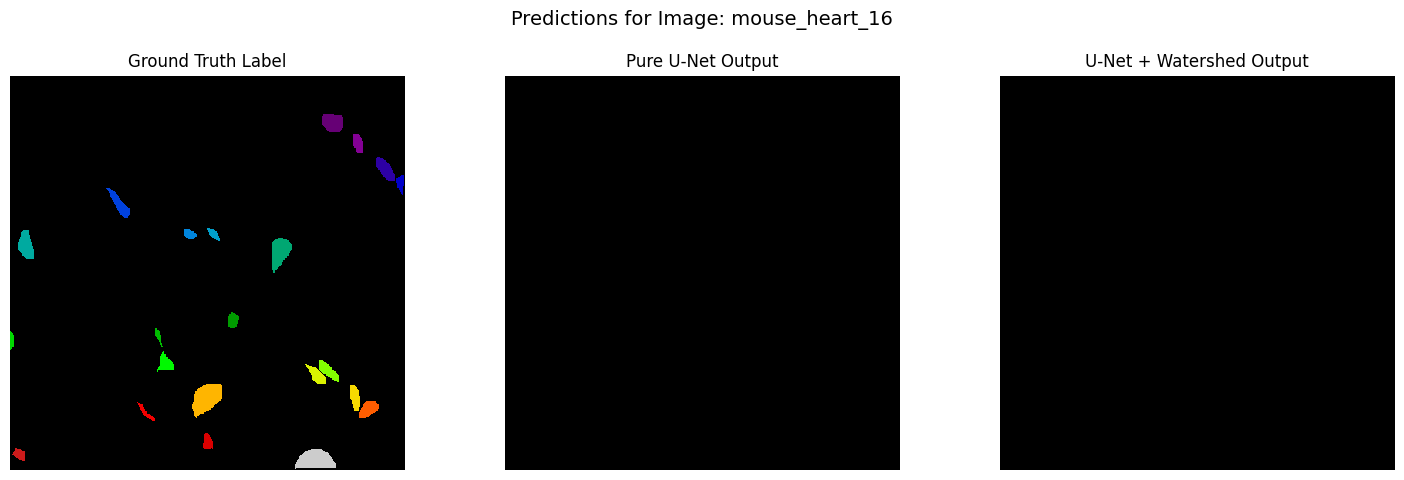

In [23]:
import matplotlib.pyplot as plt
from skimage.io import imread

# --- Configuration (Set these variables based on your environment) ---
# NOTE: The predictions must already be saved by the previous code!

# Assuming 'val_len' was the last index processed or you choose a specific index (e.g., 0)
val_index_to_view = 0 
test_name = get_id_from_file_path(test_img[val_index_to_view], '.png')

# Assuming opts['result_save_path'] is defined as in your code
# Replace this with the actual base path if 'opts' is not accessible
BASE_SAVE_PATH = opts['result_save_path'] 

# Define paths to the saved images
GT_LABEL = validation_set_label[val_index_to_view]
UNET_PATH = BASE_SAVE_PATH + 'validation/unet/{}.png'.format(test_name)
WS_PATH = BASE_SAVE_PATH + 'validation/watershed_unet/{}.png'.format(test_name)

# --- Load the saved predictions ---
try:
    unet_pred = imread(UNET_PATH)
    ws_pred = imread(WS_PATH)
except FileNotFoundError:
    print("Error: Prediction files not found. Ensure the previous code ran and saved the files correctly.")
    # Fallback/Debug: You might try displaying the final in-memory variables if available
    # print("Attempting to show in-memory variables...")
    # unet_pred = output_raw # Only works if run right after the loop
    # ws_pred = output_watershed
    
    # If using in-memory variables, ensure you remap them again:
    # unet_pred = remap_label(unet_pred)
    # ws_pred = remap_label(ws_pred)
    # GT_LABEL = remap_label(validation_set_label[val_index_to_view])
    
    
# --- Visualization ---

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Ground Truth Label", "Pure U-Net Output", "U-Net + Watershed Output"]
images = [GT_LABEL, unet_pred, ws_pred]

for ax, img, title in zip(axes, images, titles):
    # Use 'viridis' colormap for labeled images to distinguish instances
    ax.imshow(img, cmap='nipy_spectral', interpolation='none')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle(f"Predictions for Image: {test_name}", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()